In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.model_selection import train_test_split

import os

RANDOM_STATE = 42

In [2]:
import os

# Recursive find for bot data from current directory
path = None
for dirpath, dirnames, filenames in os.walk("."):
    for filename in filenames:
        if filename == "preprocessed_data.parquet":
            path = os.path.join(dirpath, filename)

assert path is not None, "bot_detection_data.csv not found in current directory or any subdirectories"
print(f"Path to csv file: {path}")

Path to csv file: .\data\preprocessed_data.parquet


In [3]:
# df = pd.read_csv(path)
df = pd.read_parquet(path)

# Drop index column, which was saved as a column in the csv
# df = df.drop(df.columns[0], axis=1)
df.head()

,Retweet Count,Mention Count,Follower Count,Verified,Bot Label,Location,Created At,w1,w2,w3,...,w961,w962,w963,w964,w965,w966,w967,w968,w969,w970
0,0.85,0.2,0.2353,0.0,1.0,0.003373,0.105605,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.55,1.0,0.9617,1.0,0.0,0.764465,0.850671,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.06,0.4,0.4363,1.0,0.0,0.257243,0.762343,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.54,1.0,0.2242,1.0,1.0,0.432733,0.474930,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.26,0.6,0.8438,0.0,1.0,0.067188,0.083336,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Get our data X and y before splitting into train and test sets
# We drop the text columns for now to see if the model even needs them for successful training.
X = df.drop('Bot Label', axis=1)
y = df['Bot Label']

X = df[["Retweet Count", "Mention Count", "Follower Count", "Verified", "Bot Label", "Location", "Created At"]]

print(X.head())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

   Retweet Count  Mention Count  Follower Count  Verified  Bot Label  \
0           0.85            0.2          0.2353       0.0        1.0   
1           0.55            1.0          0.9617       1.0        0.0   
2           0.06            0.4          0.4363       1.0        0.0   
3           0.54            1.0          0.2242       1.0        1.0   
4           0.26            0.6          0.8438       0.0        1.0   

   Location  Created At  
0  0.003373    0.105605  
1  0.764465    0.850671  
2  0.257243    0.762343  
3  0.432733    0.474930  
4  0.067188    0.083336  


In [5]:
# Check for potential class imbalance, may need to adjust loss function weights
print(len(df[df['Bot Label'] == 1]))
print(len(df[df["Bot Label"] == 0]))

25018
24982


In [ ]:
# Training
model = svm.SVC(kernel='linear')
model.fit(X_train, y_train)


SVC(kernel='linear')

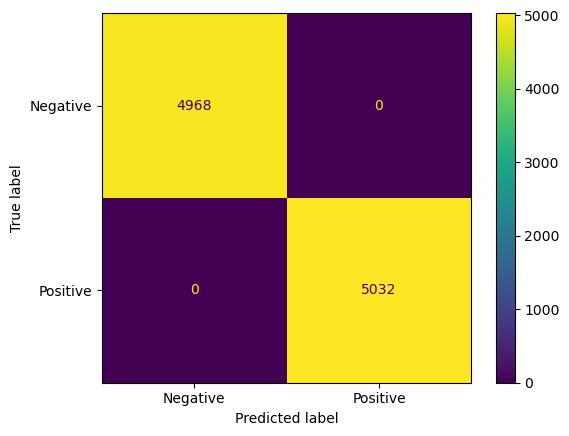

In [11]:
# Evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_hat = model.predict(X_test)

cm_test = confusion_matrix(y_test, y_hat)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Negative', 'Positive']).plot()
plt.show()


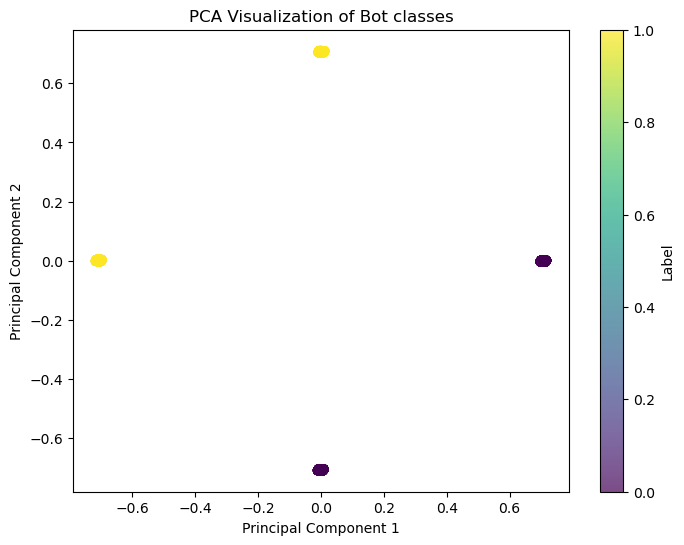

In [18]:
# 100% accuracy is suspicious, thinking overfitting
# Plot original data just to be sure
# Inspiration: https://www.datacamp.com/tutorial/introduction-t-sne
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# PCA reduces feature space by finding directions that capture the most variance
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.7)
plt.title("PCA Visualization of Bot classes")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label='Label')
plt.show()

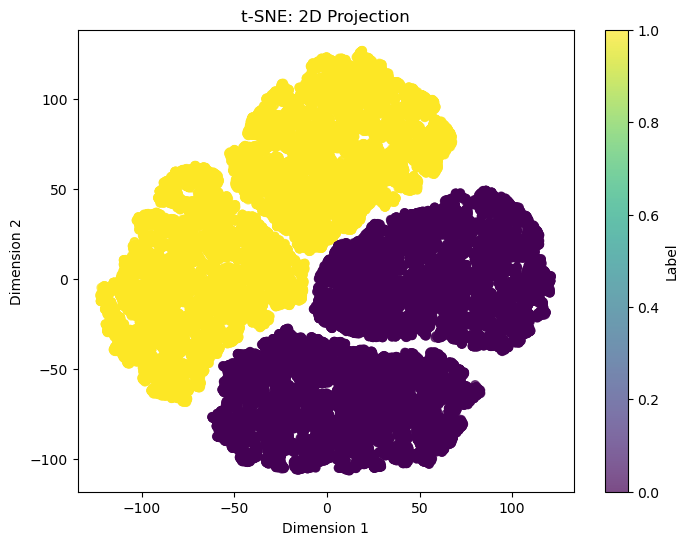

In [20]:
# Interesting, but doesn't preserve local structure very well, let's look at t-SNE
from sklearn.manifold import TSNE
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis', alpha=0.7)
plt.title("t-SNE: 2D Projection")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.colorbar(label='Label')
plt.show()

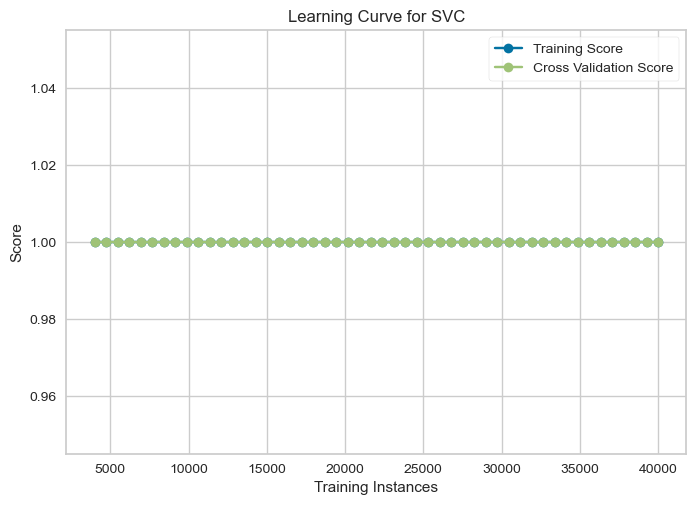

<Axes: title={'center': 'Learning Curve for SVC'}, xlabel='Training Instances', ylabel='Score'>

In [30]:
# https://www.scikit-yb.org/en/latest/api/model_selection/learning_curve.html
from yellowbrick.model_selection import LearningCurve

classifier = svm.SVC(kernel='linear')
# Uses cross validation to show model learning curve
visualizer = LearningCurve(classifier, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 50))
visualizer.fit(X, y)
visualizer.show()

# The data is just that well separated, we will need to validate on real-world data now.

In [31]:
# Try training with the text columns again, but likely unnecessary considering the high accuracy

X = df

print(X.head())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

   Retweet Count  Mention Count  Follower Count  Verified  Bot Label  \
0           0.85            0.2          0.2353       0.0        1.0   
1           0.55            1.0          0.9617       1.0        0.0   
2           0.06            0.4          0.4363       1.0        0.0   
3           0.54            1.0          0.2242       1.0        1.0   
4           0.26            0.6          0.8438       0.0        1.0   

   Location  Created At   w1   w2   w3  ...  w961  w962  w963  w964  w965  \
0  0.003373    0.105605  0.0  0.0  0.0  ...   0.0   0.0   0.0   0.0   0.0   
1  0.764465    0.850671  0.0  0.0  0.0  ...   0.0   0.0   0.0   0.0   0.0   
2  0.257243    0.762343  0.0  0.0  0.0  ...   0.0   0.0   0.0   0.0   0.0   
3  0.432733    0.474930  0.0  0.0  0.0  ...   0.0   0.0   0.0   0.0   0.0   
4  0.067188    0.083336  0.0  0.0  0.0  ...   0.0   0.0   0.0   0.0   0.0   

   w966  w967  w968  w969  w970  
0   0.0   0.0   0.0   0.0   0.0  
1   0.0   0.0   0.0   0.0   0.0  
2 

In [32]:
# Training
model = svm.SVC(kernel='linear')
model.fit(X_train, y_train)

SVC(kernel='linear')

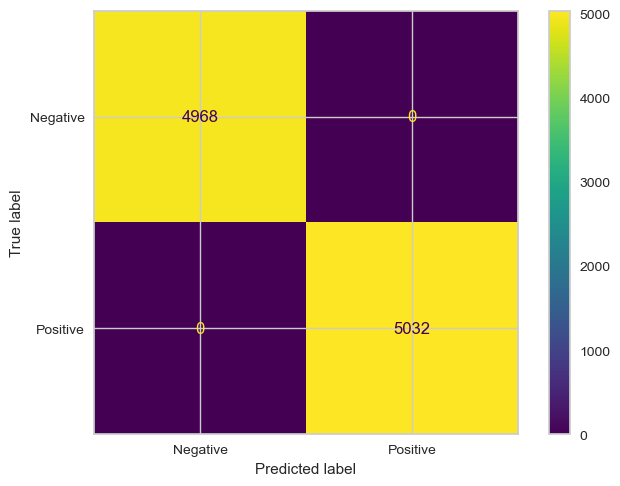

In [33]:
# Evaluation
y_hat = model.predict(X_test)

cm_test = confusion_matrix(y_test, y_hat)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Negative', 'Positive']).plot()
plt.show()